In [2]:
import os
import sys
import csv
import gzip
import numpy
import operator
import textwrap
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from collections import defaultdict
%matplotlib inline

In [2]:
# Load trait categories
reader = csv.reader(gzip.open('../data/ccs_hierarchy.csv.gz'), delimiter='\t')
reader.next()

icd9_category = dict()
#icd9_name = dict()
for icd9, icd9name, ccscat, hindex in reader:
    category = hindex.split('.')[0]
    icd9_category[icd9] = category
    #icd9_name[icd9] = icd9name

category_names = dict()
reader = csv.reader(open('../data/ccs_names_shorten.csv'), delimiter=',')
reader.next()
for hindex, longname, ccs_name in reader:
    category_names[hindex] = ccs_name
    
reader = csv.reader(open('../data/most_common_labs_cumc_withCancer.csv'))
reader.next()

lab_category = dict()
lab_names = dict()
for loinc, labname, code, category, comments in reader:
    lab_category[loinc] = [cat.strip() for cat in category.split(';')]
    lab_names[loinc] = labname
    if 'cancer' in comments.lower():
        lab_category[loinc] += ['Cancer']
        

In [3]:
# Load Trait Names
trait_names = dict()

reader = csv.reader(gzip.open('../data/loinc.csv.gz'))
reader.next()
for row in reader:
    loinc = row[0]
    name = row[1]
    trait_names[loinc] = name

reader = csv.reader(open('../data/ccs_icd9_map.txt'), delimiter='\t')
reader.next()
for icd9, name, ccscat, ccshindex in reader:
    trait_names[icd9] = name

In [4]:
float_keys = ['sampling_size', 'POSA', 'N_sig_h2s', 'h2o', 'h2o_solar_error', 'h2o_strap_lo', 'h2o_strap_hi']

In [5]:
# Load West High Quality Data (passes QC1 and QC2)
reader = csv.reader(open('../data/h2o_columbia_pass1.txt'), delimiter='\t')
header = reader.next()
print header

west_icd9 = dict()
west_lab = dict()

for row in reader:
    values = dict(zip(header, row))
    for key in float_keys:
        values[key] = float(values[key])
    trait = values['code']
    if float(values['POSA']) >= 0.7:
        if row[0] == 'icd9':
            if trait not in west_icd9 or values['sampling_size'] > west_icd9[trait]['sampling_size']:
                west_icd9[trait] = values
        if row[0] == 'lab':
            if trait not in west_lab or values['sampling_size'] > west_lab[trait]['sampling_size']:
                west_lab[trait] = values

len(west_icd9), len(west_lab)

['trait_type', 'trait', 'code', 'sampling_size', 'POSA', 'N_sig_h2s', 'h2o', 'h2o_solar_error', 'h2o_solar_pvalue', 'h2o_strap_lo', 'h2o_strap_hi']


(124, 92)

In [7]:
# Load East High Quality Data (passes QC1 and QC2)
reader = csv.reader(open('../data/h2o_cornell_pass1.txt'), delimiter='\t')
header = reader.next()
print header

east_icd9 = dict()
east_lab = dict()

for row in reader:
    values = dict(zip(header, row))
    for key in float_keys:
        values[key] = float(values[key])
    trait = values['code']
    if float(values['POSA']) >= 0.7:
        if row[0] == 'icd9':
            if trait not in east_icd9 or values['sampling_size'] > east_icd9[trait]['sampling_size']:
                east_icd9[trait] = values
        if row[0] == 'lab':
            if trait not in east_lab or values['sampling_size'] > east_lab[trait]['sampling_size']:
                east_lab[trait] = values

len(east_icd9), len(east_lab)

['trait_type', 'trait', 'code', 'sampling_size', 'POSA', 'N_sig_h2s', 'h2o', 'h2o_solar_error', 'h2o_solar_pvalue', 'h2o_strap_lo', 'h2o_strap_hi']


(76, 84)

In [8]:
# make sure all icd9 codes have a category
assert(len([dx for dx in west_icd9.keys() if not dx in icd9_category])==0)

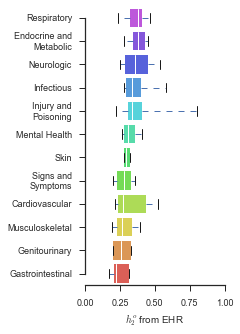

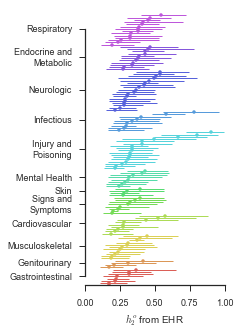

In [15]:
categories = sorted(set([icd9_category[dx] for dx in west_icd9.keys()]))
colors = sns.color_palette("hls", len(categories))

boxes = list()
cat_lists = dict()
table_data = dict()
for cat in categories:
    h2os, h2olo, h2ohi, diags = zip(*sorted([(v['h2o'],v['h2o_strap_lo'],v['h2o_strap_hi'],dx) for dx, v in west_icd9.items() if icd9_category[dx] == cat]))
    cat_lists[cat] = zip(h2os, h2olo, h2ohi)
    #print cat, len(h2os)
    if len(h2os) <= 1 or cat == '18':
        continue
    boxes.append((numpy.median(h2os), cat, h2os))
    med = numpy.median(h2os)
    pmin = numpy.min(h2os)
    pmax = numpy.max(h2os)
    table_data[cat] = (cat, category_names[cat], "%.2f (%.2f-%.2f)" % (med, pmin, pmax), diags[-1], trait_names[diags[-1]], "%.2f (%.2f-%.2f)" % (h2os[-1], h2olo[-1], h2ohi[-1]), diags[0], trait_names[diags[0]], "%.2f (%.2f-%.2f)" % (h2os[0], h2olo[0], h2ohi[0]))

boxes = sorted(boxes)
#boxes.reverse()

order, ordered_cats, boxes = zip(*boxes)
icd9_ordered_cats = ordered_cats

plt.figure(figsize=(2.5,5))

sns.set(style="ticks", color_codes=True, font_scale=0.9)

labels = ['\n'.join(textwrap.wrap(category_names[c].replace(' Diseases', ''), 17)) for c in ordered_cats]
box = plt.boxplot(boxes, labels=labels, 
                  vert=False, patch_artist=True, widths=0.8, whis=[5, 95])
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_linewidth(0)

for patch in box['medians']:
    patch.set_color('white')
    patch.set_linewidth(1)

plt.xlim(0,1)
plt.xlabel(u'$h_2^o$ from EHR')
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
sns.despine(trim=True)
plt.savefig('../results/h2o_by_disease_category.pdf')

plt.figure(figsize=(2.5,5))

ntraits = float(sum([len(v) for v in cat_lists.values()]))
y_start = 0
y_tick_pos = list()
for cat, color in zip(ordered_cats, colors):
    
    x, xlo, xhi = map(numpy.array, zip(*cat_lists[cat]))
    
    y = [y_start + i/ntraits for i in range(len(x))]
    
    plt.errorbar(x, y, xerr=[x-xlo, xhi-x], color=color, lw=1, fmt='.')
    
    y_tick_pos.append((y_start + y_start+len(x)/ntraits)/2.0)
    
    y_start += len(x)/ntraits
    
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.yticks(y_tick_pos, labels)
plt.xlabel(u'$h_2^o$ from EHR')
sns.despine(trim=True)

plt.savefig('../results/h2o_by_disease_category_individual.pdf')

icd9_colors = dict(zip(ordered_cats, colors))

In [10]:
# Now make a table out of the data as well
ofh = open('../results/h2o_disease_by_category_table.csv', 'w')
writer = csv.writer(ofh)
writer.writerow(['catcode', 'category', 'median (min-max)',
                 'lowest code', 'lowest name', 'lowest h2o (95% CI)',
                 'highest code', 'highest name', 'highest h2o (95% CI)'])
cats = [c for c in ordered_cats]
cats.reverse()
writer.writerows([table_data[cat] for cat in cats])
ofh.close()

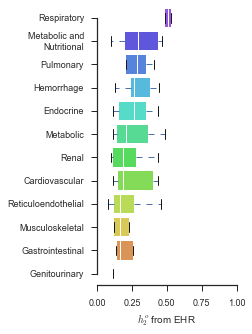

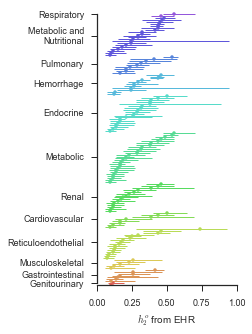

In [11]:
categories = sorted(reduce(operator.or_, [set(lab_category.get(l, set())) for l in west_lab.keys()]))
colors = sns.color_palette("hls", len(categories))

table_data = dict()
boxes = list()
cat_lists = dict()
for cat in categories:
    h2os, h2olo, h2ohi, diags = zip(*sorted([(v['h2o'],v['h2o_strap_lo'],v['h2o_strap_hi'],dx) for dx, v in west_lab.items() if cat in lab_category.get(dx,set())]))
    cat_lists[cat] = zip(h2os, h2olo, h2ohi)
    #print cat, len(h2os)
    if len(h2os) <= 1 or cat == '18':
        continue
    boxes.append((numpy.median(h2os), cat, h2os))
    med = numpy.median(h2os)
    med = numpy.median(h2os)
    pmin = numpy.min(h2os)
    pmax = numpy.max(h2os)
    table_data[cat] = (cat, "%.2f (%.2f-%.2f)" % (med, pmin, pmax), diags[-1], lab_names[diags[-1]], "%.2f (%.2f-%.2f)" % (h2os[-1], h2olo[-1], h2ohi[-1]), diags[0], lab_names[diags[0]], "%.2f (%.2f-%.2f)" % (h2os[0], h2olo[0], h2ohi[0]))


boxes = sorted(boxes)
#boxes.reverse()

order, ordered_cats, boxes = zip(*boxes)

plt.figure(figsize=(2.5,5))

sns.set(style="ticks", color_codes=True, font_scale=0.9)
labels = ['\n'.join(textwrap.wrap(c.replace(' Disorders', '').replace('_','').replace(' System',''), 19)) for c in ordered_cats]
box = plt.boxplot(boxes, labels=labels, 
                  vert=False, patch_artist=True, widths=0.8, whis=[5, 95])
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_linewidth(0)

for patch in box['medians']:
    patch.set_color('white')
    patch.set_linewidth(1)

plt.xlim(0,1)
plt.xlabel(u'$h_2^o$ from EHR')
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
sns.despine(trim=True)

plt.savefig('../results/h2o_by_lab_category.pdf')

plt.figure(figsize=(2.5,5))

ntraits = float(sum([len(v) for v in cat_lists.values()]))
y_start = 0
y_tick_pos = list()
for cat, color in zip(ordered_cats, colors):
    
    x, xlo, xhi = map(numpy.array, zip(*cat_lists[cat]))
    
    y = [y_start + i/ntraits for i in range(len(x))]
    
    plt.errorbar(x, y, xerr=[x-xlo, xhi-x], color=color, lw=1, fmt='.')
    
    y_tick_pos.append((y_start + y_start+len(x)/ntraits)/2.0)
    
    y_start += len(x)/ntraits
    
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.yticks(y_tick_pos, labels)
plt.xlabel(u'$h_2^o$ from EHR')
sns.despine(trim=True)

#plt.tight_layout()

plt.savefig('../results/h2o_by_lab_category_individual.pdf')


In [12]:
# Now make a table out of the data as well
ofh = open('../results/h2o_lab_by_category_table.csv', 'w')
writer = csv.writer(ofh)
writer.writerow(['category', 'median (min-max)',
                 'lowest code', 'lowest name', 'lowest h2o (95%CI)',
                 'highest code', 'highest name', 'highest h2o (95% CI)'])
cats = [c for c in ordered_cats]
cats.reverse()
writer.writerows([table_data[cat] for cat in cats])
ofh.close()

   Rs   h2o Category
-0.23  0.11 Infectious Diseases
 0.24 -0.17 Genitourinary Diseases
 0.10 -0.04 Skin Diseases
-0.21 -0.15 Musculoskeletal Diseases
 0.21  0.10 Injury and Poisoning
-0.32 -0.20 Signs and Symptoms
-0.29  0.19 Endocrine and Metabolic Diseases
-0.11  0.02 Mental Health Diseases
 0.15  0.18 Neurologic Diseases
-0.18 -0.11 Cardiovascular Diseases
 0.18  0.22 Respiratory Diseases
 0.21 -0.30 Gastrointestinal Diseases


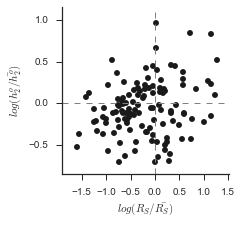

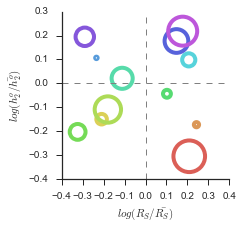

In [16]:
# Load the sib recurrence rates for some of the diagnoses and compare them to heritability
reader = csv.reader(open('../data/h2o_versus_sibrecurrence_121traits.csv'))
reader.next()

hvr = dict()
colors = list()
cat_list = defaultdict(list)
for dx, h2o, sibrec in reader:
    hvr[dx]  = (float(h2o), float(sibrec))
    if not icd9_category[dx] in icd9_ordered_cats:
        colors.append((.7, .7, .7))
    #elif icd9_category[dx] != '8':
    #    colors.append((.7, .7, .7))
    else:
        colors.append(icd9_colors[icd9_category[dx]])
        cat_list[icd9_category[dx]].append((float(h2o), float(sibrec)))

y, x = map(numpy.array, zip(*hvr.values()))

sns.set(style="ticks", color_codes=True, font_scale=1.0)

plt.figure(figsize=(3,3))

x = numpy.log(x/numpy.mean(x))
y = numpy.log(y/numpy.mean(y))
plt.scatter(x, y, color='k', s=35, alpha=1.0, lw=0)
plt.ylabel(r'$log(h_2^o/\bar{h_2^o})$')
plt.xlabel(r'$log(R_S/\bar{R_S})$')

m = 0.2
x_bounds = [(1+m)*min(x), (1+m)*max(x)]
y_bounds = [(1+m)*min(y), (1+m)*max(y)]
plt.xlim(x_bounds)
plt.ylim(y_bounds)

plt.plot(x_bounds, [0, 0], '--', lw=1, color='grey')
plt.plot([0, 0], y_bounds, '--', lw=1, color='grey')

sns.despine(trim=False)

plt.savefig('../results/h2o_versus_sibrecurrence_121traits.pdf')



plt.figure(figsize=(3,3))

x = list()
y = list()
colors = list()
sizes = list()

for cat in sorted(cat_list.keys()):
    
    h2os, sibrecs = zip(*cat_list[cat])
    x.append(numpy.median(sibrecs))
    y.append(numpy.median(h2os))
    colors.append(icd9_colors[cat])
    sizes.append(len(x)*len(y))

x = numpy.array(x)
y = numpy.array(y)

x = numpy.log(x/numpy.mean(x))
y = numpy.log(y/numpy.mean(y))

print r"   Rs   h2o Category"
for cat, xx, yy in zip(sorted(cat_list.keys()), x, y):
    print "%5.2f %5.2f %s" % (xx, yy, category_names[cat])

sizes = numpy.array(sizes)
sizes = 1000*sizes/max(sizes)

plt.scatter(x, y, color='none', s=sizes, alpha=1.0, lw=4, edgecolors=colors)
plt.ylabel(r'$log(h_2^o/\bar{h_2^o})$')
plt.xlabel(r'$log(R_S/\bar{R_S})$')

m = 0.3
#x_bounds = [(1+m)*min(x), (1+m)*max(x)]
#y_bounds = [(1+m)*min(y), (1+m)*max(y)]
x_bounds = [-0.4, 0.4]
y_bounds = [-0.4, 0.3]
plt.xlim(x_bounds)
plt.ylim(y_bounds)

plt.plot(x_bounds, [0, 0], '--', lw=1, color='grey')
plt.plot([0, 0], y_bounds, '--', lw=1, color='grey')

sns.despine(trim=False)

plt.savefig('../results/h2o_versus_sibrecurrence_121traits_bycategory.pdf')


Statistical analysis of differences is in the notebook: Heritability_AllResults


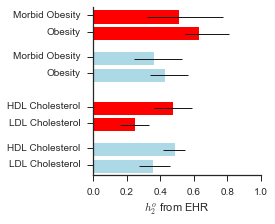

In [17]:
plt.figure(figsize=(3,3))
sns.set(style="ticks", color_codes=True, font_scale=1.0)

#traits = ['9830-1', '2093-3', '2089-1', '2085-9']
traits = ['2089-1', '2085-9']
names = ['LDL Cholesterol', 'HDL Cholesterol']
ntraits = float(len(traits))

lefts = numpy.arange(ntraits)
heights = numpy.array([west_lab[t]['h2o'] for t in traits])
lower = numpy.array([west_lab[t]['h2o_strap_lo'] for t in traits])
upper = numpy.array([west_lab[t]['h2o_strap_hi'] for t in traits])

plt.barh(lefts, heights, xerr=(heights-lower, upper-heights), ecolor='k', lw=0, color='lightblue', error_kw={'linewidth':1})
plt.ylim(0,1)

xtickdata = list()
for l, t, n in zip(lefts, traits, names):
    xtickdata.append( (l+0.5, '\n'.join(textwrap.wrap(n, 18)) ))

lefts = numpy.arange(ntraits) + ntraits + 0.5
heights = numpy.array([east_lab[t]['h2o'] for t in traits])
lower = numpy.array([east_lab[t]['h2o_strap_lo'] for t in traits])
upper = numpy.array([east_lab[t]['h2o_strap_hi'] for t in traits])

for l, t, n in zip(lefts, traits, names):
    xtickdata.append( (l+0.5, '\n'.join(textwrap.wrap(n, 18)) ))

plt.barh(lefts, heights, xerr=(heights-lower, upper-heights), ecolor='k', lw=0, color='red', error_kw={'linewidth':1})


traits2 = ['278.00', '278.01']
names = ['Obesity', 'Morbid Obesity']
ntraits2 = float(len(traits2))

lefts = numpy.arange(ntraits2) + 2*ntraits + 1.5
heights = numpy.array([west_icd9[t]['h2o'] for t in traits2])
lower = numpy.array([west_icd9[t]['h2o_strap_lo'] for t in traits2])
upper = numpy.array([west_icd9[t]['h2o_strap_hi'] for t in traits2])

plt.barh(lefts, heights, xerr=(heights-lower, upper-heights), ecolor='k', lw=0, color='lightblue', error_kw={'linewidth':1})


for l, t, n in zip(lefts, traits2, names):
    xtickdata.append( (l+0.5, '\n'.join(textwrap.wrap(n, 18)) ))

lefts = numpy.arange(ntraits2) + ntraits2 + 1.5 + 2*ntraits + 0.5
heights = numpy.array([east_icd9[t]['h2o'] for t in traits2])
lower = numpy.array([east_icd9[t]['h2o_strap_lo'] for t in traits2])
upper = numpy.array([east_icd9[t]['h2o_strap_hi'] for t in traits2])

for l, t, n in zip(lefts, traits2, names):
    xtickdata.append( (l+0.5, '\n'.join(textwrap.wrap(n, 18)) ))

plt.barh(lefts, heights, xerr=(heights-lower, upper-heights), ecolor='k', lw=0, color='red', error_kw={'linewidth':1})

pos, lab = zip(*xtickdata)
plt.yticks(pos, lab)

plt.ylim(-0.1, max(lefts)+1)
plt.xlabel("$h_2^o$ from EHR")
plt.xlim(0,1)
sns.despine(trim=False)

plt.savefig('../results/h2o_west_east_obesity_and_cholesterol.pdf')

print "Statistical analysis of differences is in the notebook: Heritability_AllResults"

In [18]:
len(set(west_icd9.keys()) | set(west_lab.keys()) | set(east_icd9.keys()) | set(east_lab.keys()))

291